In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
def get_gaussian_maps(mu, shape_hw, inv_std, mode='ankush'):
    """
    from https://github.com/tomasjakab/imm/blob/0fee6b24466a5657d66099694f98036c3279b245/imm/models/imm_model.py#L34
  
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.
    STD: is the fixed standard dev.
    """
    with tf.name_scope(None, 'gauss_map', [mu]):
        mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]
        y = tf.to_float(tf.linspace(-1.0, 1.0, shape_hw[0]))

        x = tf.to_float(tf.linspace(-1.0, 1.0, shape_hw[1]))

    if mode in ['rot', 'flat']:
        mu_y, mu_x = tf.expand_dims(mu_y, -1), tf.expand_dims(mu_x, -1)

        y = tf.reshape(y, [1, 1, shape_hw[0], 1])
        x = tf.reshape(x, [1, 1, 1, shape_hw[1]])

        g_y = tf.square(y - mu_y)
        g_x = tf.square(x - mu_x)
        dist = (g_y + g_x) * inv_std**2

        if mode == 'rot':
            g_yx = tf.exp(-dist)
        else:
            g_yx = tf.exp(-tf.pow(dist + 1e-5, 0.25))

    elif mode == 'ankush':
        y = tf.reshape(y, [1, 1, shape_hw[0]])
        x = tf.reshape(x, [1, 1, shape_hw[1]])

        g_y = tf.exp(-tf.sqrt(1e-4 + tf.abs((mu_y - y) * inv_std)))
        g_x = tf.exp(-tf.sqrt(1e-4 + tf.abs((mu_x - x) * inv_std)))

        g_y = tf.expand_dims(g_y, axis=3)
        g_x = tf.expand_dims(g_x, axis=2)
        g_yx = tf.matmul(g_y, g_x)  # [B, NMAPS, H, W]

    else:
        raise ValueError('Unknown mode: ' + str(mode))

    g_yx = tf.transpose(g_yx, perm=[0, 2, 3, 1])
    return g_yx

In [3]:
def _get_gaussian_maps(mu, shape_hw, inv_std):
    """
    from https://github.com/tomasjakab/imm/blob/0fee6b24466a5657d66099694f98036c3279b245/imm/models/imm_model.py#L34
  
    Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
    given the gaussian centers: MU [B, NMAPS, 2] tensor.
    STD: is the fixed standard dev.
    """
    mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]
    y = tf.linspace(-1.0, 1.0, shape_hw[0])

    x = tf.linspace(-1.0, 1.0, shape_hw[1])



    #elif mode == 'ankush':
    y = tf.reshape(y, [1, 1, shape_hw[0]])
    x = tf.reshape(x, [1, 1, shape_hw[1]])

    g_y = tf.exp(-tf.sqrt(1e-4 + tf.abs((mu_y - y) * inv_std)))
    g_x = tf.exp(-tf.sqrt(1e-4 + tf.abs((mu_x - x) * inv_std)))

    g_y = tf.expand_dims(g_y, axis=3)
    g_x = tf.expand_dims(g_x, axis=2)
    g_yx = tf.matmul(g_y, g_x)  # [B, NMAPS, H, W]

    g_yx = tf.transpose(g_yx, perm=[0, 2, 3, 1])
    return g_yx

In [4]:
# https://github.com/tomasjakab/imm/blob/0fee6b24466a5657d66099694f98036c3279b245/imm/models/imm_model.py#L252
def get_coord(other_axis, axis_size):
    ## x is output of the final pose encoder conv layer- should be B,H,W,NMAP
    # get "x-y" coordinates:
    g_c_prob = tf.reduce_mean(x, axis=other_axis)  # B,W,NMAP
    g_c_prob = tf.nn.softmax(g_c_prob, axis=1)  # B,W,NMAP
    coord_pt = tf.to_float(tf.linspace(-1.0, 1.0, axis_size)) # W
    coord_pt = tf.reshape(coord_pt, [1, axis_size, 1]) ## 1,W,1
    g_c = tf.reduce_sum(g_c_prob * coord_pt, axis=1) # compute expectation along axis, scaled by coord_pt
    return g_c, g_c_prob

"""
      xshape = x.shape.as_list()
      gauss_y, gauss_y_prob = get_coord(2, xshape[1])  # B,NMAP
      gauss_x, gauss_x_prob = get_coord(1, xshape[2])  # B,NMAP
      gauss_mu = tf.stack([gauss_y, gauss_x], axis=2)

      tf.add_to_collection('tensors', ('gauss_y_prob', gauss_y_prob))
      tf.add_to_collection('tensors', ('gauss_x_prob', gauss_x_prob))

      gauss_xy = []
      for map_size in map_sizes:
        gauss_xy_ = get_gaussian_maps(gauss_mu, [map_size, map_size],
                                      1.0 / self._config.gauss_std,
                                      mode=gauss_mode)
        gauss_xy.append(gauss_xy_)"""

"\n      xshape = x.shape.as_list()\n      gauss_y, gauss_y_prob = get_coord(2, xshape[1])  # B,NMAP\n      gauss_x, gauss_x_prob = get_coord(1, xshape[2])  # B,NMAP\n      gauss_mu = tf.stack([gauss_y, gauss_x], axis=2)\n\n      tf.add_to_collection('tensors', ('gauss_y_prob', gauss_y_prob))\n      tf.add_to_collection('tensors', ('gauss_x_prob', gauss_x_prob))\n\n      gauss_xy = []\n      for map_size in map_sizes:\n        gauss_xy_ = get_gaussian_maps(gauss_mu, [map_size, map_size],\n                                      1.0 / self._config.gauss_std,\n                                      mode=gauss_mode)\n        gauss_xy.append(gauss_xy_)"

In [5]:
def _get_coord(x, other_axis, axis_size):
    ## x is output of the final pose encoder conv layer- should be B,H,W,NMAP
    # get "x-y" coordinates:
    g_c_prob = tf.reduce_mean(x, axis=other_axis)  # B,W,NMAP
    g_c_prob = tf.nn.softmax(g_c_prob, axis=1)  # B,W,NMAP
    #coord_pt = tf.to_float(tf.linspace(-1.0, 1.0, axis_size)) # W
    coord_pt = tf.linspace(-1.0, 1.0, axis_size) # W
    coord_pt = tf.reshape(coord_pt, [1, axis_size, 1]) ## 1,W,1
    g_c = tf.reduce_sum(g_c_prob * coord_pt, axis=1) # compute expectation along axis, scaled by coord_pt
    return g_c, g_c_prob

In [6]:
B = 3
H = 5
W = 7
NMAP = 11

pose_encoder_maps = np.random.normal(0, 1, size=(B,H,W,NMAP)).astype(np.float32)

In [7]:
gauss_y, gauss_y_probs = _get_coord(pose_encoder_maps, 2, pose_encoder_maps.shape[1])
gauss_x, gauss_x_probs = _get_coord(pose_encoder_maps, 1, pose_encoder_maps.shape[2])
gauss_mu = tf.stack([gauss_y, gauss_x], axis=2)

In [8]:
gauss_y.shape

TensorShape([3, 11])

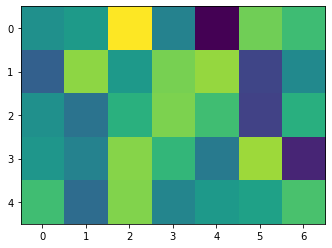

In [9]:
plt.imshow(pose_encoder_maps[0,:,:,0])

In [10]:
gauss_mu.shape

TensorShape([3, 11, 2])

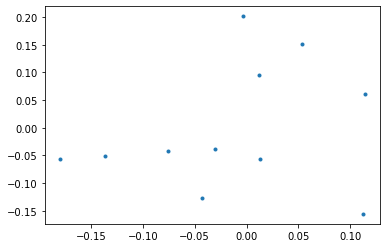

In [11]:
plt.plot(gauss_mu[0,:,0], gauss_mu[0,:,1], ".")

In [12]:
map_size = 10
gauss_std = 0.1
gauss_xy_ = _get_gaussian_maps(gauss_mu, [map_size, map_size],
                                      1.0 /gauss_std)

In [13]:
gauss_xy_.shape

TensorShape([3, 10, 10, 11])

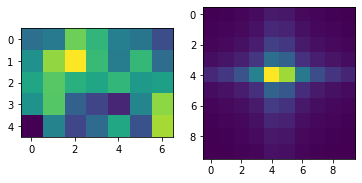

In [14]:
i = 2
j = 1
plt.subplot(121)
plt.imshow(pose_encoder_maps[i,:,:,j])
plt.subplot(122)
plt.imshow(gauss_xy_[i,:,:,j])

In [15]:
def generate_gaussians(pose_maps, std=0.1):
    gauss_y, gauss_y_probs = _get_coord(pose_maps, 2, pose_maps.shape[1])
    gauss_x, gauss_x_probs = _get_coord(pose_maps, 1, pose_maps.shape[2])
    gauss_mu = tf.stack([gauss_y, gauss_x], axis=2)
    gauss_xy_ = _get_gaussian_maps(gauss_mu, pose_maps.shape[1:3], 1.0 /std)
    return gauss_xy_

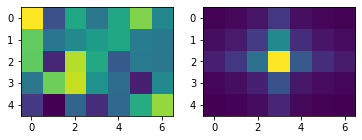

In [16]:
i = 0
j = 2
plt.subplot(121)
plt.imshow(pose_encoder_maps[i,:,:,j])
plt.subplot(122)
plt.imshow(generate_gaussians(pose_encoder_maps)[i,:,:,j])